# 네트워크 기기 상태 이상 현상 검증

## 문제 상황
네트워크 기기 상태를 보여주는 시계열 지표를 통해 이상 현상을 발견하는 머신러닝 모델을 구축했습니다. 이번 작업의 목표는 모델이 예측한 이상 현상을 재검증하는 것입니다. 이를 위해 지표의 Shapley value를 통해 검증하고, 시계열 지표와 Shapley value의 유사성을 동적 시간 왜곡(DTW)을 통해 분석합니다.

## 데이터 생성
우선, 가상의 시계열 지표 데이터와 해당 지표의 Shapley value 데이터를 생성합니다.


In [1]:
# !pip install dtw

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(42)

# 시간 범위 생성 (100시간)
time_index = pd.date_range(start='2023-01-01', periods=100, freq='h')

# 가상의 시계열 지표 데이터 생성
cpu_usage = np.sin(np.linspace(0, 20, 100)) + np.random.normal(scale=0.5, size=100)
memory_usage = np.cos(np.linspace(0, 20, 100)) + np.random.normal(scale=0.5, size=100)

# Shapley value 데이터 생성
Shapley_cpu_usage = cpu_usage + np.random.normal(scale=0.1, size=100)
Shapley_memory_usage = np.sin(np.linspace(0, 40, 100)) + np.random.normal(scale=0.5, size=100)  # 완전히 다른 패턴

# 데이터프레임 생성
data = pd.DataFrame(data={'CPU_Usage': cpu_usage, 'Memory_Usage': memory_usage, 'Shapley_CPU_Usage': Shapley_cpu_usage, 'Shapley_Memory_Usage': Shapley_memory_usage}, index=time_index)

# 데이터 확인
data.head()

,CPU_Usage,Memory_Usage,Shapley_CPU_Usage,Shapley_Memory_Usage
2023-01-01 00:00:00,0.248357,0.292315,0.284136,-0.414498
2023-01-01 01:00:00,0.131517,0.769341,0.187595,0.113046
2023-01-01 02:00:00,0.716981,0.748123,0.825286,1.096609
2023-01-01 03:00:00,1.331149,0.420760,1.436529,1.241548
2023-01-01 04:00:00,0.605886,0.610244,0.468119,0.988520


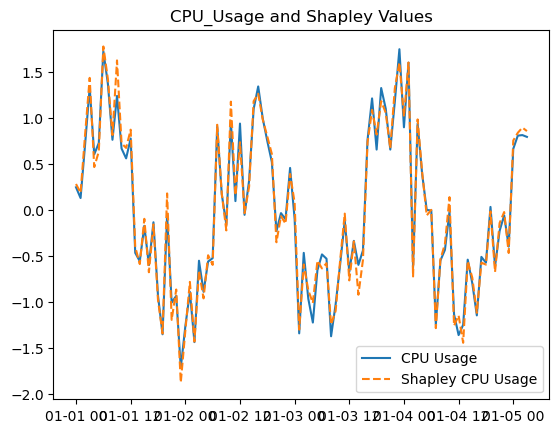

In [3]:
plt.plot(data['CPU_Usage'], label='CPU Usage')
plt.plot(data['Shapley_CPU_Usage'], label='Shapley CPU Usage', linestyle='--')
plt.legend()
plt.title('CPU_Usage and Shapley Values')
plt.show()

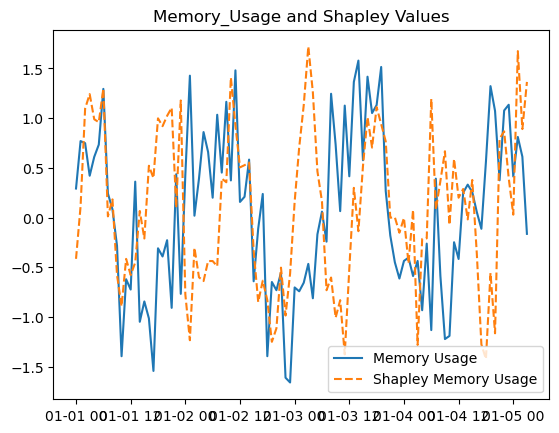

In [4]:
plt.plot(data['Memory_Usage'], label='Memory Usage')
plt.plot(data['Shapley_Memory_Usage'], label='Shapley Memory Usage', linestyle='--')
plt.legend()
plt.title('Memory_Usage and Shapley Values')
plt.show()


## 동적 시간 왜곡(DTW) 설명
DTW(Dynamic Time Warping)는 두 시계열의 유사성을 측정하는 기법입니다. DTW는 두 시계열의 특정 패턴을 시간 축을 따라 변형하여 최적의 일치를 찾습니다. 이 과정에서 시계열의 길이가 다르거나, 시간 축이 왜곡된 경우에도 유사성을 평가할 수 있습니다.

## DTW 유사성 분석
가상의 지표 CPU_Usage와 Shapley_CPU_Usage, 그리고 Memory_Usage와 Shapley_Memory_Usage의 DTW 유사성을 분석합니다.


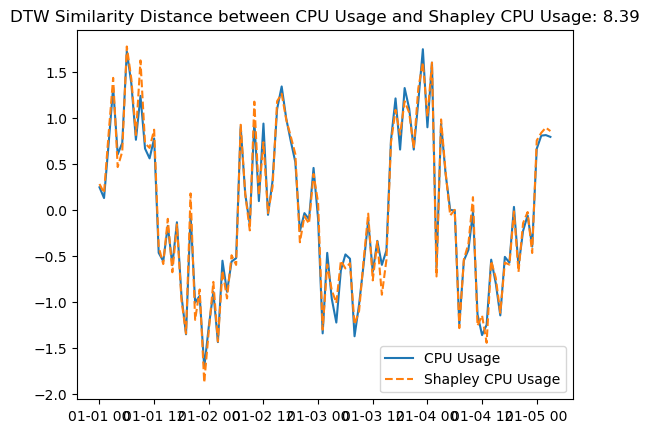

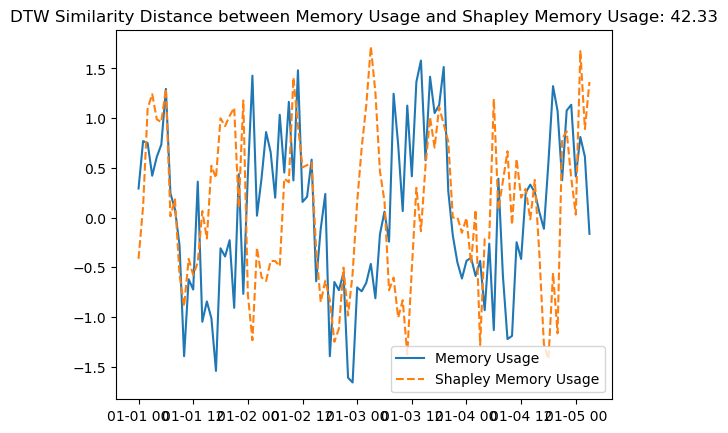

In [5]:
from dtw import dtw
from scipy.spatial.distance import euclidean

# DTW 유사성 계산
alignment_cpu_usage = dtw(data['CPU_Usage'].values.reshape(-1, 1), 
                          data['Shapley_CPU_Usage'].values.reshape(-1, 1), 
                          dist=euclidean)
alignment_memory_usage = dtw(data['Memory_Usage'].values.reshape(-1, 1), 
                             data['Shapley_Memory_Usage'].values.reshape(-1, 1), 
                             dist=euclidean)

# DTW 거리 추출
cpu_distance = alignment_cpu_usage[0]
memory_distance = alignment_memory_usage[0]

# DTW 유사성 시각화
plt.plot(data.index, data['CPU_Usage'], label='CPU Usage')
plt.plot(data.index, data['Shapley_CPU_Usage'], label='Shapley CPU Usage', linestyle='--')
plt.title(f'DTW Similarity Distance between CPU Usage and Shapley CPU Usage: {cpu_distance:.2f}')
plt.legend()
plt.show()

plt.plot(data.index, data['Memory_Usage'], label='Memory Usage')
plt.plot(data.index, data['Shapley_Memory_Usage'], label='Shapley Memory Usage', linestyle='--')
plt.title(f'DTW Similarity Distance between Memory Usage and Shapley Memory Usage: {memory_distance:.2f}')
plt.legend()
plt.show()


## 비즈니스 의사결정
이상 현상의 예측 및 검증을 통해 네트워크 관리자는 기기의 이상 현상을 보다 신뢰성 있게 탐지하고 대응할 수 있습니다. Shapley value와 지표의 유사성을 확인함으로써 모델의 예측을 검증하고, 불필요한 경고를 줄이며, 신속한 문제 해결을 위한 근거를 마련할 수 있습니다.

